# **Baseline measurements**

Measurements with all the available occupation data:
- No federated learning
- 55 days available for learning
- 5 days for testing

In [1]:
EPOCHS = 100
TRAIN = range(0, 55)
TEST = range(55, 60)

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import neural_network
import utils

from importlib import reload
reload(neural_network);

## **Data preparation**

In [3]:
MEAS_ROOT = "../dockeroutput/"

In [4]:
#reading capacity data:
MOST_PATH = "../build_inputs//MoSTScenario/scenario/most.sumocfg"
PARKING_AREA_DEFINITIONS = "../build_inputs/MoSTScenario/scenario/in/add/most.parking.add.xml"

parking_df = pd.read_xml(PARKING_AREA_DEFINITIONS)
parking_df = parking_df[parking_df["roadsideCapacity"]>0]
parking_df = parking_df.set_index(["id"])

In [5]:
#constants for normalizing/standardizing:
nominals = pd.read_csv(MEAS_ROOT+"day_0/occupancies.csv")
perc_ = []
for i,r in nominals.iterrows():
    perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
nominals["percentage"] = perc_

In [6]:
MEAN = np.mean(nominals["percentage"])
STD = np.std(nominals["percentage"])
MIN_T = 14400
MAX_T = 50460

PARKING_ID_LIST = [i for i in range(1059, 1186+1)]

In [7]:
def collect_data(day_range):
    collected_data = None
    for day in day_range:
        meas_path = MEAS_ROOT + "day_%d/"%day
        df_ = pd.read_csv(meas_path+"occupancies.csv")
        perc_ = []
        for i,r in df_.iterrows():
            perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
        df_["percentage"] = perc_

        #one-hot-encoding:
        ohe = utils.one_hot_encoder(df_["ids"], PARKING_ID_LIST)
        #standardizing percentage values:
        percentages = np.array(df_["percentage"]).reshape(len(df_), 1)
        percentages = utils.standardize(percentages, MEAN, STD)
        #normalizing time values:
        times = np.array(df_["timestamp"]).reshape(len(df_), 1)
        times = utils.normalize(times, MIN_T, MAX_T)

        new_data = np.hstack([ohe, times, percentages])
        if collected_data is None:
            collected_data = new_data
        else:
            collected_data = np.vstack([collected_data, new_data])
    return collected_data

In [8]:
train_data = pd.DataFrame(collect_data(TRAIN))
train_data.to_csv("../02_data/nn_baseline_train.csv", header=False, index=False)

In [9]:
test_data = collect_data(TEST)

In [10]:
test_data = pd.DataFrame(test_data)
test_data.to_csv("../02_data/nn_baseline_test.csv", header=False, index=False)

## **Learning**

In [7]:
train_data = pd.read_csv("../02_data/nn_baseline_train.csv", header=None)

In [8]:
nn = neural_network.NeuralNetwork()

2023-02-08 12:22:57.191768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:22:57.236015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:22:57.236202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:22:57.237444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
train_data = np.array(train_data.sample(frac=0.33))
#train_data = data[:int(len(data)*.7)]
#test_data = data[int(len(data)*.7)+1:]

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = nn.model.fit(train_data[:,:-1],
                       train_data[:,-1], batch_size=1000, epochs=EPOCHS, validation_split=.3,
                       callbacks=[callback])
#eval_model = nn.model.evaluate(test_data[:,:-1], test_data[:,-1], batch_size=1000)

Epoch 1/100


2023-02-08 12:23:12.910401: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 999100356 exceeds 10% of free system memory.


  80/1937 [>.............................] - ETA: 3s - loss: 0.4658 

2023-02-08 12:23:14.284848: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1937/1937 [==============================] - 6s 2ms/step - loss: 0.0572 - val_loss: 0.0155
Epoch 2/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0077 - val_loss: 0.0083
Epoch 3/100
1937/1937 [==============================] - 4s 2ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 4/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 5/100
1937/1937 [==============================] - 4s 2ms/step - loss: 0.0037 - val_loss: 0.0103
Epoch 6/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 7/100
1937/1937 [==============================] - 4s 2ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 8/100
1937/1937 [==============================] - 5s 2ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 9/100
1937/1937 [==============================] - 4s 2ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 10/100
1937/1937 [==============================] - 4s 2ms/step - loss: 0.0026 

In [11]:
history.history

{'loss': [0.057234711945056915,
  0.007692764047533274,
  0.0052165198139846325,
  0.004276522900909185,
  0.00371812772937119,
  0.0033933536615222692,
  0.0031084271613508463,
  0.002918832004070282,
  0.0027437538374215364,
  0.0026078822556883097,
  0.0024834759533405304,
  0.0023753789719194174,
  0.0022986559197306633,
  0.0022476250305771828,
  0.002160850213840604,
  0.002088741632178426,
  0.002058787737041712,
  0.0019875408615916967,
  0.0019454890862107277,
  0.0018997006118297577,
  0.0018408282194286585,
  0.0018237640615552664,
  0.0017843329114839435,
  0.0017469265731051564],
 'val_loss': [0.015467716380953789,
  0.00834574457257986,
  0.009104988537728786,
  0.002551422454416752,
  0.010320923291146755,
  0.003757694736123085,
  0.005190587602555752,
  0.002274228958413005,
  0.004344024229794741,
  0.0018134827259927988,
  0.006945373956114054,
  0.002381361788138747,
  0.003201564773917198,
  0.0024324983824044466,
  0.0015938798896968365,
  0.0021929156500846148,
 

### Saving the model

In [12]:
nn.model.save("../04_nn_models/baseline")

INFO:tensorflow:Assets written to: ../04_nn_models/baseline/assets


## **Testing**

In [13]:
nn.model = keras.models.load_model("../04_nn_models/baseline")

In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Learning curves')

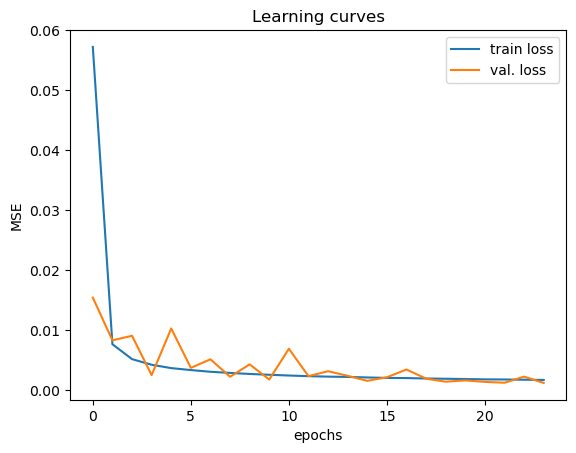

In [15]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val. loss")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning curves")

### **Testing with a specific parking lot**

In [16]:
PARKING_ID = 1150

In [17]:
id_list = PARKING_ID_LIST

test_t = np.arange(14400, 50400, 60)
test_t = utils.normalize(test_t, MIN_T, MAX_T)

id_encoding = utils.one_hot_encoder([PARKING_ID]*len(test_t), id_list)
#print(id_encoding.shape)

test_d = np.hstack([id_encoding, test_t.reshape(len(test_t), 1)])
#print(test_d.shape)

output = nn.model.predict(test_d)
output = utils.de_standardize(output, MEAN, STD)

19/19 [==============================] - 0s 742us/step


In [18]:
oracle = pd.read_csv("../02_data/oracle.csv")
oracle

,ids,timestamp,counts,percentage
0,1059,14460,0,0.0
1,1060,14460,0,0.0
2,1061,14460,0,0.0
3,1062,14460,0,0.0
4,1063,14460,0,0.0
...,...,...,...,...
9143995,1182,50400,0,0.0
9143996,1183,50400,0,0.0
9143997,1184,50400,0,0.0
9143998,1185,50400,0,0.0


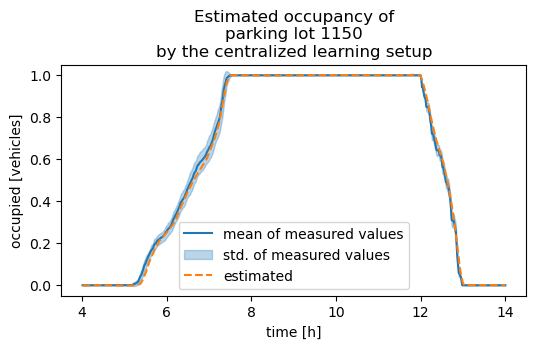

In [23]:
plt.figure(figsize=[6,3])
p_lot = oracle[oracle["ids"] == PARKING_ID]
p_lot_occup_mean = p_lot.groupby("timestamp")["percentage"].mean()
p_lot_occup_std = p_lot.groupby("timestamp")["percentage"].std()
plt.plot(p_lot_occup_mean.index/(60*60), p_lot_occup_mean, label="mean of measured values")
plt.fill_between(p_lot_occup_mean.index/(60*60), p_lot_occup_mean-p_lot_occup_std,
                 p_lot_occup_mean+p_lot_occup_std, alpha=0.3, color="tab:blue",
                 label="std. of measured values")
plt.plot(p_lot_occup_mean.index/(60*60), output, "--", label="estimated")
plt.xlabel("time [h]")
plt.ylabel("occupied [vehicles]")
plt.legend()
plt.title("Estimated occupancy of\nparking lot %d\nby the centralized learning setup"%PARKING_ID)
plt.ylim(-.05, 1.05)
plt.show()

### **Testing with the last 5 days**

In [24]:
test_data = pd.read_csv("../02_data/nn_baseline_test.csv", header=None)
test_data = np.array(test_data)

In [25]:
result = nn.model.evaluate(test_data[:,:-1],
                  test_data[:,-1], batch_size=1000)

print("Test loss:\t%.4f"%result)

762/762 [==============================] - 1s 1ms/step - loss: 0.0014
Test loss:	0.0014
